In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt




In [2]:
def contour_search(image, thresh=100):
    if type(image) is str: 
        my_photo = cv2.imread(image)
    else: my_photo = image
    filterd_image  = cv2.medianBlur(my_photo,7)
    img_grey = cv2.cvtColor(filterd_image,cv2.COLOR_BGR2GRAY)

    #set a thresh
    thresh = thresh

    #get threshold image
    ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)

    #find contours
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #create an empty image for contours
    img_contours = np.uint8(np.zeros((my_photo.shape[0],my_photo.shape[1])))

    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)

#     cv2.imshow('origin', my_photo) # выводим итоговое изображение в окно
#     cv2.imshow('res', img_contours) # выводим итоговое изображение в окно
    return (my_photo, img_contours, contours)

In [3]:
def contour_search_2(image, eps=0.005):
    if type(image) is str: 
        img = cv2.imread(image)
    else: img = image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = 100

    #get threshold image
    ret,thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)

    # find contours without approx
    contours,_ = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    max=0
    sel_countour=None
    for countour in contours:
        if countour.shape[0]>max:
            sel_countour=countour
            max=countour.shape[0]

    # calc arclentgh
    arclen = cv2.arcLength(sel_countour, True)

    # do approx
    eps = eps
    epsilon = arclen * eps
    approx = cv2.approxPolyDP(sel_countour, epsilon, True)

    # draw the result
    canvas = img.copy()
    for pt in approx:
        cv2.circle(canvas, (pt[0][0], pt[0][1]), 2, (0,255,0), -1)

    cv2.drawContours(canvas, [approx], -1, (255,0,0), 1, cv2.LINE_AA)

    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, [approx], -1, (255,255,255), 1)
    
    return (canvas, img_contours, contours)

In [25]:
image = '../data/pprofile_max/test/8.png'
stock, img_contour, contours = contour_search(image)

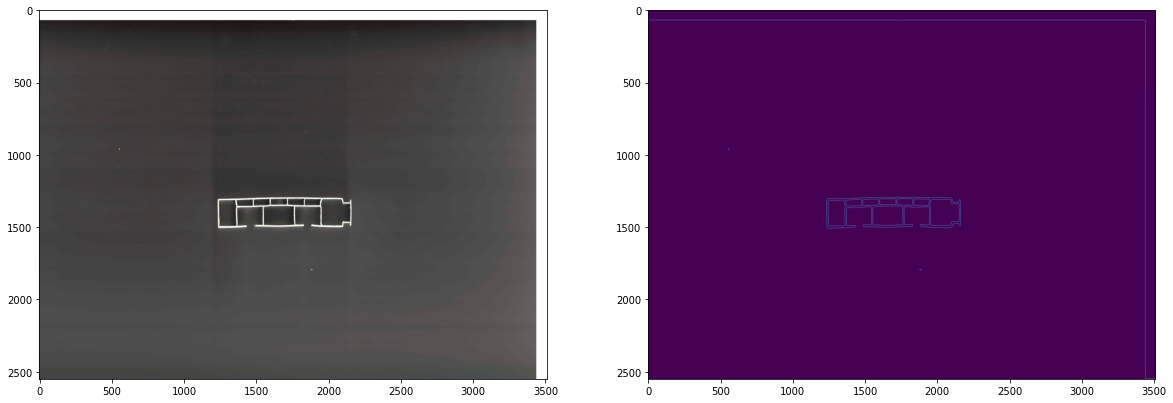

In [26]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(stock)
plt.subplot(2, 2, 2)
plt.imshow(img_contour)
plt.show()


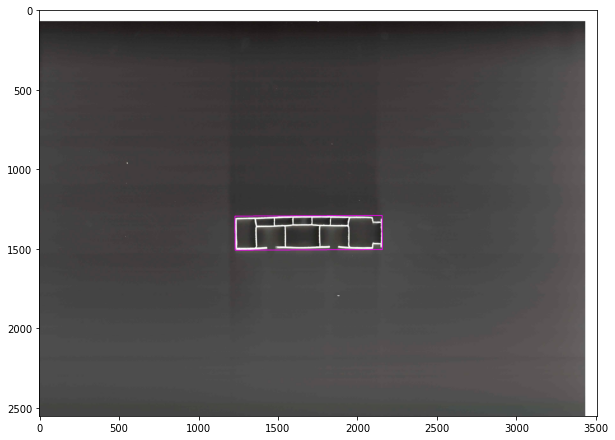

In [27]:
im1 = cv2.imread(image)
# im2 = cv2.minAreaRect(im1)
rect = cv2.minAreaRect(contours[1])
box = cv2.boxPoints(rect)
box = np.int0(box)
im2 = cv2.drawContours(im1,[box],0,(255,0,255),4)
plt.figure(figsize=(10, 10))
plt.imshow(im2)

In [8]:
print(rect)

((1696.13720703125, 1399.5457763671875), (213.78741455078125, 926.0936279296875), 89.78779602050781)


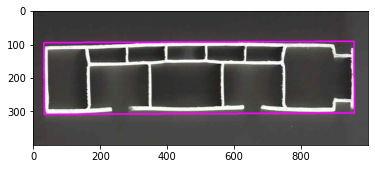

In [9]:
im3 = im1[1200:1600, 1200:2200]
plt.imshow(im3)

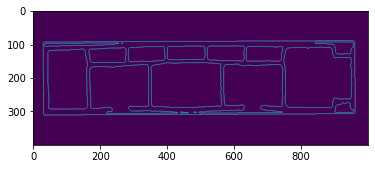

In [10]:
_, im4, c_  = contour_search(im3)
plt.imshow(im4)

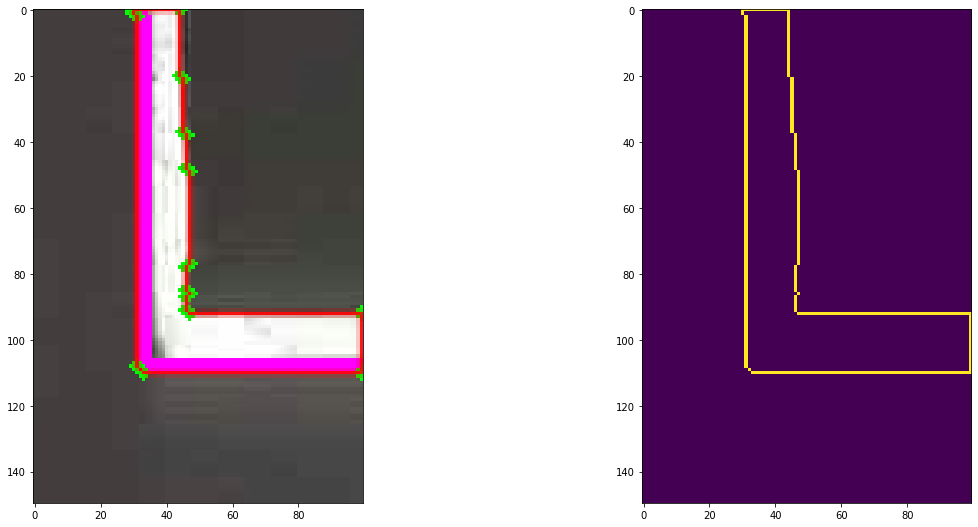

In [11]:
left_bottom = im3[200:350, 0:100]
canvas, im6, c_  = contour_search_2(left_bottom, 0.001, )
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(canvas)
plt.subplot(2, 2, 2)
plt.imshow(im6)
plt.show()

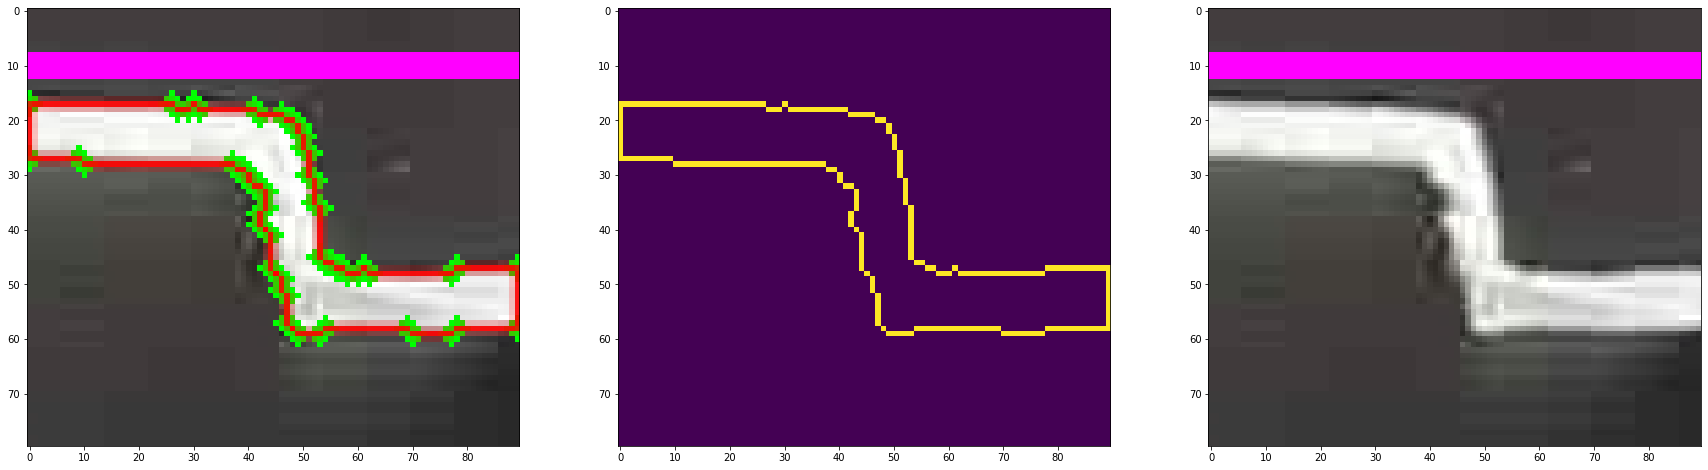

In [12]:
right_up = im3[80:160, 850:940]
canvas, im7, c_  = contour_search_2(right_up, 0.0001, )
plt.figure(figsize=(30, 30))
plt.subplot(3, 3, 1)
plt.imshow(canvas)
plt.subplot(3, 3, 2)
plt.imshow(im7)
plt.subplot(3, 3, 3)
plt.imshow(right_up)
plt.show()

In [13]:
1+3

4

In [765]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou_score = intersection / union
    return iou_score



In [766]:
im1 = cv2.imread('../data/pprofile_max/test/8.png')
im2 = cv2.imread('../data/pprofile_max/test/mask_3510x2550.png')


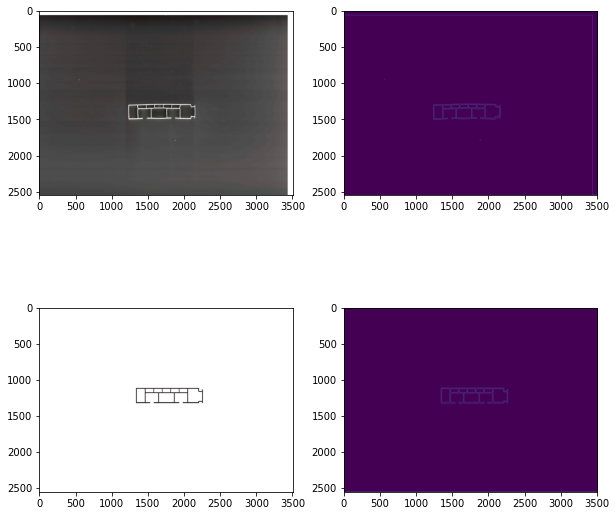

In [767]:
s1, img_contour1, contours1 = contour_search(im1)
s2, img_contour2, contours2 = contour_search(im2)

n = 2
m = 2
plt.figure(figsize=(10, 10))
plt.subplot(n, m, 1)
plt.imshow(s1)
plt.subplot(n, m, 2)
plt.imshow(img_contour1)
plt.subplot(n, m, 3)
plt.imshow(s2)
plt.subplot(n, m, 4)
plt.imshow(img_contour2)
plt.show()

In [768]:
def fill_contour(contour, img, color=(255,0,0)):
    
    height, width = img.shape
    # создание пустой маски
    mask = np.zeros((height, width), dtype=np.uint8)

    # заполнение маски контуром
    im = cv2.fillPoly(mask, [contour], color=color)
    
    return im

In [769]:
def mask_profile(contours, img, color=(255,0,0)):
    for contour in contours:
        img = fill_contour(contour, img, color)
    return img

In [770]:
def minAreaBox(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    x = []
    y = []
    for point in box:
        x.append(point[0])
        y.append(point[1])
    xmax = max(x)
    ymax = max(y)
    xmin = min(x)
    ymin = min(y)
    return box, (xmin, ymin, xmax, ymax)

In [771]:
def fill_wall(image, inv=False):
    # преобразование изображения в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # бинаризация изображения для выделения контуров
    _, binary = cv2.threshold(gray, thresh=0, maxval=255, type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    if inv == True:
        binary = cv2.bitwise_not(binary)
    
    # морфологическая обработка для устранения шумов и заполнения контуров
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # поиск контуров и создание маски стенок сот
    height, width = morph.shape
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros((height, width), dtype=np.uint8)
    im = cv2.drawContours(mask, contours, -1, color=1, thickness=-1)
    return morph
    

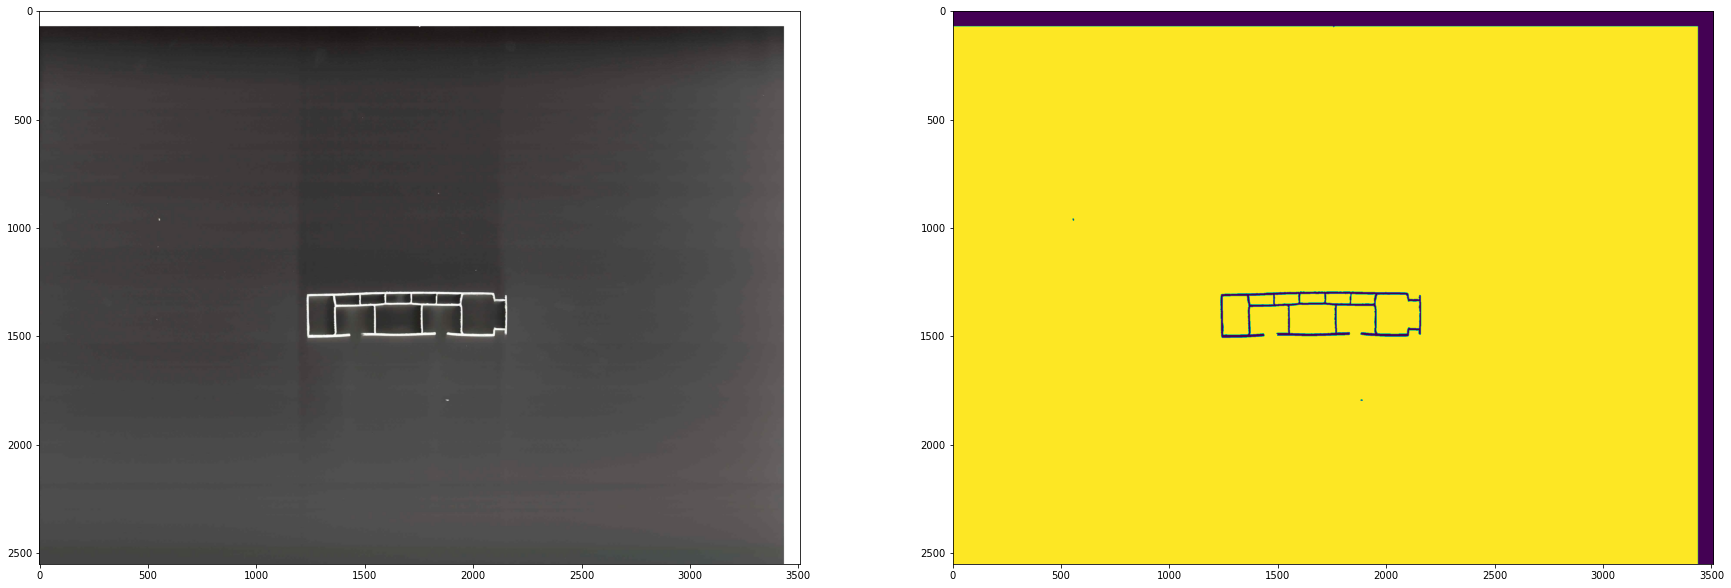

In [772]:
im1_ = fill_wall(im1)

n = 1
m = 2
plt.figure(figsize=(30, 30))
plt.subplot(n, m, 1)
plt.imshow(im1)
plt.subplot(n, m, 2)
plt.imshow(im1_)

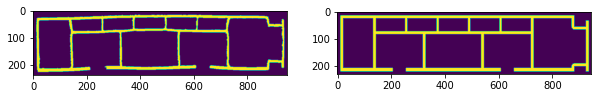

In [773]:
box, (xmin, ymin, xmax, ymax) = minAreaBox(contours1[1])
im1_ = fill_wall(im1, inv=True)
# im1 = cv2.drawContours(im1,[box],0,(255,0,255),4)
# im1_ = fill_contour(contours1[1], img_contour1, 1)
# im1_ = mask_profile(contours1[1:4], img_contour1, 1)
im1_crop = im1_[ymin-10:ymax+10, xmin-10:xmax+10]

box, (xmin, ymin, xmax, ymax) = minAreaBox(contours2[1])
im2_ = fill_wall(im2)
# im2 = cv2.drawContours(im2,[box],0,(255,0,255),4)
im2_crop = im2_[ymin-10:ymax+10, xmin-10:xmax+10]

n = 1
m = 2
plt.figure(figsize=(10, 10))
plt.subplot(n, m, 1)
plt.imshow(im1_crop)
plt.subplot(n, m, 2)
plt.imshow(im2_crop)

In [774]:
h1, w1 = im1_crop.shape 
h2, w2 = im2_crop.shape
hmax = max(h1, h2)
wmax = max(w1, w2)
if h1 >= h2:
    im1_crop = im1_crop[0:h2, 0:]
else:
    im2_crop = im2_crop[0:h1, 0:]
if w1 >= w2:
    im1_crop = im1_crop[0:, 0:w2]
else:
    im2_crop = im2_crop[0:, 0:w1]


iou(im1_crop, im2_crop)

0.529269228439311

In [775]:
def combine_mask(mask1, mask2, AND=True, OR=False):
    # создание изображения для закраски
    canvas = np.zeros_like(mask1)
    
    assert (AND==True or OR==True)
    assert (AND==False or OR==False)
    # совмещение масок
    if AND:
        mask = cv2.bitwise_and(mask1, mask2)
    if OR:
        mask = cv2.bitwise_or(mask1, mask2)
    
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    

    # определение контуров областей пересечения масок
#     contours, hierarchy = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # закраска областей пересечения масок на изображении canvas
#     com_mask = cv2.fillPoly(canvas, contours, color=(255, 255, 255))
#     com_mask = cv2.drawContours(canvas, contours, -1, color=1, thickness=-1)
    
    
    return mask

In [776]:
def switch_color(img, color_aim=(255,255,255), color_new=(255,0,0)):
    # создание маски для пикселей целевого цвета
    color_aim = np.array(color_aim)
    aim_mask = cv2.inRange(img, color_aim, color_aim)
    
    # создание маски для пикселей не целевого цвета
    not_aim_mask = cv2.bitwise_not(aim_mask)
    
    h, w, c = img.shape
    # замена цвета на новый
    bg = np.zeros((h,w,c), np.uint8)
    bg[:] = color_new
    new_mask = bg

    img = cv2.bitwise_and(img, img, mask=not_aim_mask)
    img = cv2.add(img, new_mask, mask=aim_mask)
    
    return img

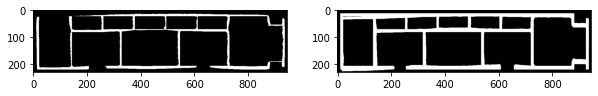

In [777]:
and_mask = combine_mask(im2_crop, im1_crop, AND=True, OR=False)
or_mask = combine_mask(im2_crop, im1_crop, AND=False, OR=True)
n = 1
m = 2
plt.figure(figsize=(10, 10))
plt.subplot(n, m, 1)
plt.imshow(and_mask)
plt.subplot(n, m, 2)
plt.imshow(or_mask)

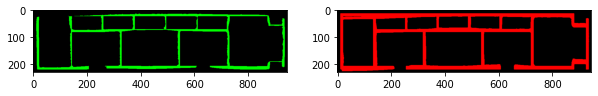

In [778]:
# com_mask = switch_color(com_mask, [255,255,255], [255,0,0])
c = 255
or_mask_color = switch_color(or_mask, color_aim=(c,c,c), color_new=(255,0,0))
and_mask_color = switch_color(and_mask, color_aim=(c,c,c), color_new=(0,255,0))
n = 1
m = 2
plt.figure(figsize=(10, 10))
plt.subplot(n, m, 1)
plt.imshow(and_mask_color)
plt.subplot(n, m, 2)
plt.imshow(or_mask_color)

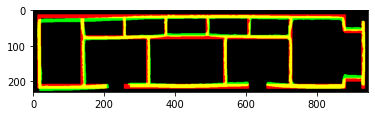

In [795]:
im2_crop_color = cv2.cvtColor(im2_crop, cv2.COLOR_GRAY2RGB)
im2_crop_color = switch_color(im2_crop_color, (255,255,255), (255,0,0))
im1_crop_color = cv2.cvtColor(im1_crop, cv2.COLOR_GRAY2RGB)
im1_crop_color = switch_color(im1_crop_color, (255,255,255), (0,255,0))

conmask = cv2.add(im2_crop_color, im1_crop_color)
plt.imshow(conmask)

In [801]:
def counter(img):
    yellow_pixels = 0
    red_pixels = 0
    h, w, c = img.shape
    # проход по всем пикселям изображения
    for i in range(h):
        for j in range(w):
            # проверка пикселя на желтый цвет
            if img[i, j] == (255, 255, 0):
                yellow_pixels += 1
            elif img[i, j] == (255, 0, 0):
                red_pixels += 1
    
    return yellow_pixels / red_pixels, yellow_pixels, red_pixels

In [802]:
print(counter(conmask)[0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [849]:
a = conmask[0][0]
a


array([0, 0, 0], dtype=uint8)